In [10]:
import wbgapi as wb
import wbdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


from sklearn.metrics import r2_score

import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

<h1 style="color:black; background-color:white; padding:10px; padding-bottom:10px;text-align: center;">Green dimensions</h1>

---

In [6]:
def load_and_name_db_WB(db, *args):
    global df_name
    df_name = db
    globals()[df_name] = wb.data.DataFrame(value1, wb.region.members(value2), range(value3, value4))

    return globals()[df_name]

In [7]:
value1 = ['EN.ATM.CO2E.PC',"NY.GDP.MKTP.KD.ZG",'SL.UEM.TOTL.ZS']
value2 = "WLD"
value3 = 2019
value4 = 2020

load_and_name_db_WB("df_original", value1, value2, value3, value4)

,EN.ATM.CO2E.PC,NY.GDP.MKTP.KD.ZG,SL.UEM.TOTL.ZS
economy,,,
ABW,NaN,0.635029,NaN
AFG,0.160850,3.911603,11.085
AGO,0.779292,-0.700000,9.481
ALB,1.691968,2.088063,11.470
AND,6.573595,2.015548,NaN
...,...,...,...
XKX,NaN,4.756831,NaN
YEM,0.351701,NaN,12.978
ZAF,7.568640,0.303453,25.540


In [8]:
def rename_columns_and_drop_na(df, column_mapping):
    # Rename columns
    df = df.rename(columns=column_mapping)

    # Drop rows with missing values
    df = df.dropna()

    return df

# Example usage
# Assuming you have a DataFrame named 'df' and a dictionary of column mapping named 'column_mapping'
column_mapping = {'EN.ATM.CO2E.PC': 'CO2_per_cap', 'NY.GDP.MKTP.KD.ZG': 'GDP_growth', 'SL.UEM.TOTL.ZS': 'Unemployment'}
new_df = rename_columns_and_drop_na(df_original, column_mapping)
new_df

,CO2_per_cap,GDP_growth,Unemployment
economy,,,
AFG,0.160850,3.911603,11.085
AGO,0.779292,-0.700000,9.481
ALB,1.691968,2.088063,11.470
ARE,20.502131,1.108348,2.330
ARG,3.740546,-2.000861,9.840
...,...,...,...
VUT,0.692501,3.241188,1.757
WSM,1.394021,4.451859,9.147
ZAF,7.568640,0.303453,25.540


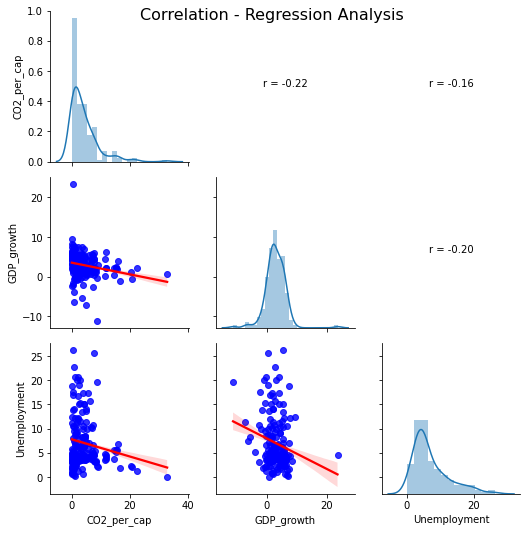

In [110]:
from scipy.stats import pearsonr
def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r, p = pearsonr(x, y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

def reg_plot(x, y, **kwargs):
    color = kwargs.pop('color', 'red')
    sns.regplot(x, y, color=color, ci=68, scatter_kws={'color': 'blue'}, line_kws={'color': color}, **kwargs)

g = sns.PairGrid(new_df)
g.map_diag(sns.distplot)
g.map_lower(reg_plot, color='red')
g.map_upper(reg_coef)

plt.suptitle('Correlation - Regression Analysis', fontsize=16)

plt.show()

In [158]:
def dimensional_reduction(dataframe):
    # Standardize the data
    dataframe = dataframe.dropna()
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(dataframe)

    # Perform PCA
    pca = PCA()
    pca.fit(standardized_data)

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variance_ratio)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    # Scree plot to visualize explained variance ratio
    axs[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    axs[0].set_xlabel('Number of Components', fontsize=12)
    axs[0].set_ylabel('Explained Variance Ratio', fontsize=12)
    axs[0].set_title('Explained Variance Ratio by Principal Components', fontsize=14)

    # Cumulative variance plot
    axs[1].plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o')
    axs[1].set_xlabel('Number of Components', fontsize=12)
    axs[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
    axs[1].set_title('Cumulative Variance Explained by Principal Components', fontsize=14)
    axs[1].axhline(0.90, c="r")

    # Find the number of components exceeding the threshold
    n_components = np.argmax(cumulative_variances >= 0.78) + 1

    # Add text annotation to the second scatter plot
    axs[1].text(n_components, cumulative_variances[n_components - 1], f'The optimal number of components\n to explain at least 80% variance is: {n_components}', fontsize=12,
                ha='left', va='top')


    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()


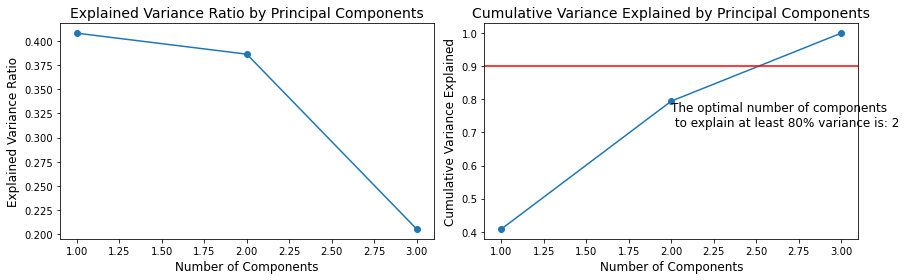

In [159]:
dimensional_reduction(new_df)

In [170]:
import numpy as np
from sklearn.cluster import KMeans

def dimensional_reduction3(df, model):
    df = df.dropna(axis=0, how='any')

    dm = model
    dm = dm.fit(df)
    global df_tr
    df_tr = dm.transform(df)
    dm_df = pd.DataFrame(data=dm.components_, columns=df.columns.values, index=range(len(dm.components_)))

    fig = plt.figure(figsize=(12, 10))

    # Plot the correlation heatmap
    ax_heatmap = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    sns.heatmap(dm_df, vmin=-1, vmax=1, annot=True, cmap='RdBu', ax=ax_heatmap)
    ax_heatmap.set_title('Correlation Heatmap', fontsize=14)

    # Plot the scatter plot of PCA components with KMeans clustering
    ax_scatter1 = plt.subplot2grid((2, 2), (1, 0))
    ax_scatter1.scatter(df_tr[:, 0], df_tr[:, 1], c=KMeans(n_clusters=2).fit_predict(df_tr))
    ax_scatter1.set_title('PCA Scatter Plot with KMeans Clustering', fontsize=14)
    ax_scatter1.set_xlabel('Principal Component 1', fontsize=12)
    ax_scatter1.set_ylabel('Principal Component 2', fontsize=12)

    # Plot the second scatter plot with column names as labels
    ax_scatter2 = plt.subplot2grid((2, 2), (1, 1))
    ax_scatter2.scatter(dm.components_[0], dm.components_[1])
    ax_scatter2.set_title('Scatter Plot 2', fontsize=14)
    ax_scatter2.set_xlabel('Principal Component 1', fontsize=12)
    ax_scatter2.set_ylabel('Principal Component 2', fontsize=12)

    for i, txt in enumerate(df.columns):
        ax_scatter2.annotate(txt, (dm.components_[0][i], dm.components_[1][i]), fontsize=10)  # Increase font size here

    plt.tight_layout()
    plt.show()

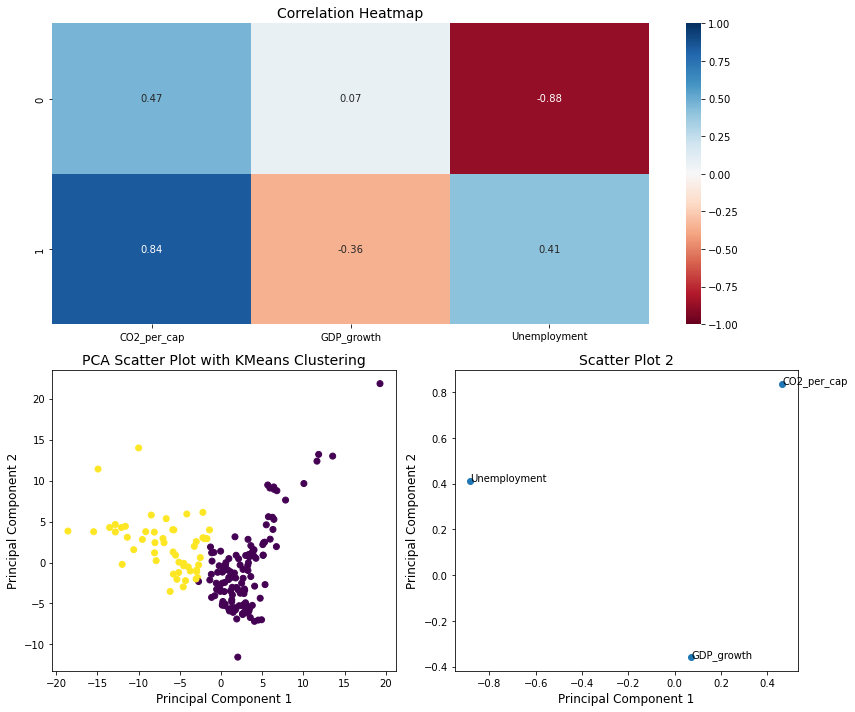

In [171]:
dimensional_reduction3(new_df, PCA(2))

In [181]:
def tsne (df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)

    X = df  # Replace 'target' with the actual column name

    # Define different perplexity values and random seeds
    perplexities = [5, 10, 20]  # Add more perplexity values if desired
    random_seeds = [42, 100, 200]  # Add more random seeds if desired


    # Create subplots for each combination of perplexity and random seed
    fig, axs = plt.subplots(len(perplexities), len(random_seeds), figsize=(12, 12))

    # Iterate through each perplexity value
    for i, perplexity in enumerate(perplexities):
        # Iterate through each random seed
        for j, random_seed in enumerate(random_seeds):
            # Perform t-SNE with 2 components
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_seed)
            X_tsne = tsne.fit_transform(X)

            # Perform clustering on the t-SNE transformed data
            kmeans = KMeans(n_clusters=2, random_state=42)
            cluster_labels = kmeans.fit_predict(X_tsne)

            # Plot the t-SNE transformed data
            axs[i, j].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels)
            axs[i, j].set_xlabel('Component 1')
            axs[i, j].set_ylabel('Component 2')
            axs[i, j].set_title(f"Perplexity: {perplexity}, Random Seed: {random_seed}")

    # Adjust spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

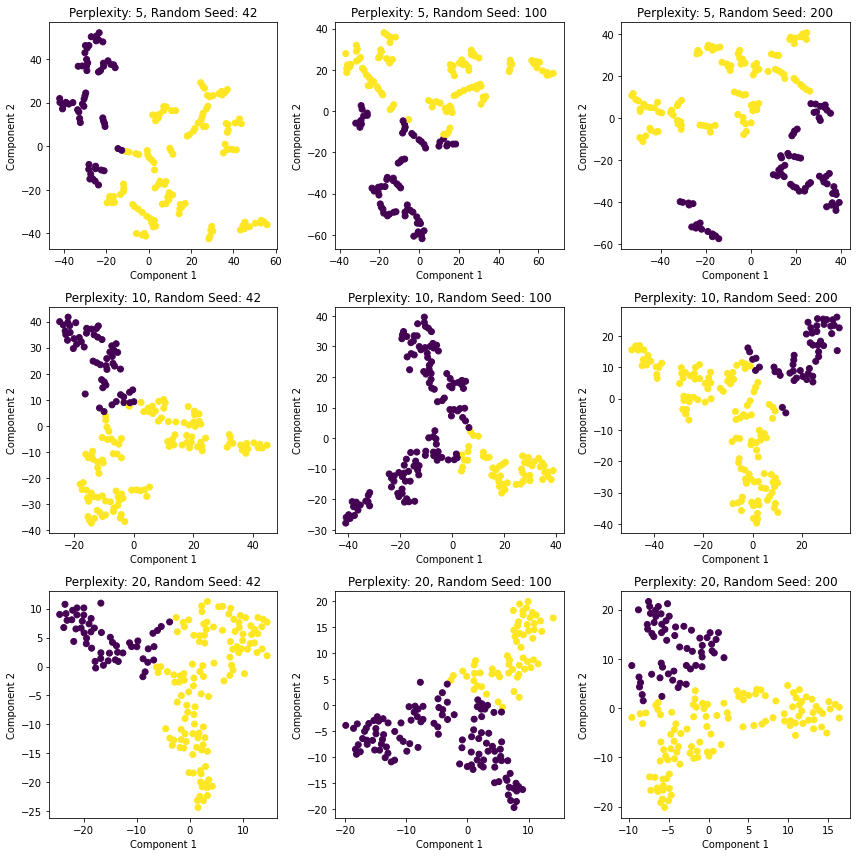

In [182]:
tsne(new_df)

In [14]:
def tsne(df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)

    X = standardized_data

    perplexities = [5, 10, 20]
    random_seeds = [42, 100, 200]

    fig, axs = plt.subplots(len(perplexities), len(random_seeds), figsize=(12, 12))

    for i, perplexity in enumerate(perplexities):
        for j, random_seed in enumerate(random_seeds):
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_seed)
            X_tsne = tsne.fit_transform(X)

            kmeans = KMeans(n_clusters=2, random_state=42)
            cluster_labels = kmeans.fit_predict(X_tsne)

            axs[i, j].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels)
            axs[i, j].scatter(X_tsne[df.index == 'BGR', 0], X_tsne[df.index== 'BGR', 1], c='r')
            axs[i, j].set_xlabel('Component 1')
            axs[i, j].set_ylabel('Component 2')
            axs[i, j].set_title(f"Perplexity: {perplexity}, Random Seed: {random_seed}")
            axs[i, j].legend()


    fig.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

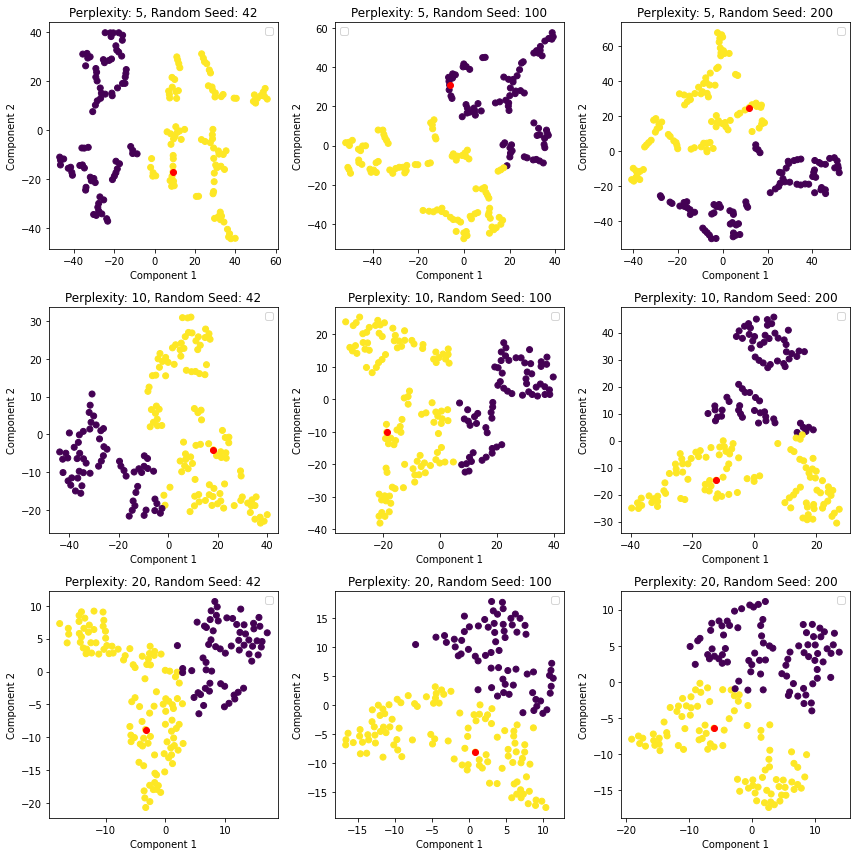

In [15]:
tsne(new_df)

In [22]:
def tsne(df):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)

    X = standardized_data

    perplexities = [5, 10, 20]
    random_seeds = [42, 100, 200]

    fig, axs = plt.subplots(len(perplexities), len(random_seeds), figsize=(12, 12))

    for i, perplexity in enumerate(perplexities):
        for j, random_seed in enumerate(random_seeds):
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_seed)
            X_tsne = tsne.fit_transform(X)

            kmeans = KMeans(n_clusters=2, random_state=42)
            cluster_labels = kmeans.fit_predict(X_tsne)

            axs[i, j].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', label='Cluster')
            axs[i, j].scatter(X_tsne[df.index == 'BGR', 0], X_tsne[df.index == 'BGR', 1], c='r', label='BGR')
            axs[i, j].scatter(X_tsne[df.index == 'WLD', 0], X_tsne[df.index == 'WLD', 1], c='b', label='WLD')
            axs[i, j].set_xlabel('Component 1')
            axs[i, j].set_ylabel('Component 2')
            axs[i, j].set_title(f"Perplexity: {perplexity}, Random Seed: {random_seed}")
            axs[i, j].legend()

    fig.tight_layout()
    plt.show()


In [ ]:
tsne(new_df)